### AIT 614 - Big Data Essentials <br>
#### DL2 Team 3 Final Project
#### Detecting Abrasive online user content

##### Team 3
Yasser Parambathkandy

Indranil Pal

Deepak Rajan

<br>

##### University
George Mason University



##### Installation

###### Databricks:
On an existing cluster, add the following to the Advanced Options -> Spark tab:
``` 
  spark.kryoserializer.buffer.max 2000M
  spark.serializer org.apache.spark.serializer.KryoSerializer
```

In Libraries tab inside the cluster:
  * Install New -> PyPI -> spark-nlp==4.4.0 -> Install
  * Install New -> Maven -> Coordinates -> com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.0 -> Install
  
Refer https://github.com/JohnSnowLabs/spark-nlp#databricks-cluster for installation issues

###### Local Machine:
See README
<br>

##### Data load

Upload train.csv to databricks. It should get loaded to dbfs:/FileStore/tables/train.csv
For local development, update train.csv file path in second cell below
<br>
##### Saving Model

Save model to use in real-time prediction services. The model gets saved to S3 bucket if runtime environment is databricks and AWS accesskey csv has been uploaded to dbfs:/FileStore/tables/ait614_databricks_accessKeys.csv. If either condition is not satisfied, then model is not saved in databricks. To overwrite the file path, bucket name, update properties in second cell below
For local development, model is always saved.

Saved model is used by prediction services when user enter new questions in UI.

In [14]:
import datetime
import os

import matplotlib.pyplot as plt
import sparknlp
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when, explode
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sparknlp.annotator import *
from sparknlp.base import *

In [15]:
#set properties for local machine development and databricks

# check if running in Databricks by looking for the DATABRICKS_RUNTIME_VERSION environment variable
if "DATABRICKS_RUNTIME_VERSION" in os.environ:
    # set the CSV file path for Databricks
    train_file_path = 'dbfs:/FileStore/tables/train.csv'
    aws_s3_keys = 'dbfs:/FileStore/tables/ait614_databricks_accessKeys.csv'
    s3_mount_path = '/mnt/ait614-models'
    s3_bucket_name = 'ait614-models'
else:
    # set the training file path for local machine. when running in jupyter notebook relative path doesn't work, so provide full path
    train_file_path = '/home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv'
    spark = sparknlp.start()

print('training file path {}'.format(train_file_path))

training file path /home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv


In [16]:
# Read the CSV file
schema = "qid STRING, question_text STRING, target INT"
df = spark.read.option("header", "true")\
            .option("delimiter", ",")\
            .option("multiLine", "true")\
            .option("quote", "\"")\
            .option("escape", "\"")\
            .schema(schema).csv(train_file_path)

df.printSchema()
df.show(10)

root
 |-- qid: string (nullable = true)
 |-- question_text: string (nullable = true)
 |-- target: integer (nullable = true)

+--------------------+--------------------+------+
|                 qid|       question_text|target|
+--------------------+--------------------+------+
|00002165364db923c7e6|How did Quebec na...|     0|
|000032939017120e6e44|Do you have an ad...|     0|
|0000412ca6e4628ce2cf|Why does velocity...|     0|
|000042bf85aa498cd78e|How did Otto von ...|     0|
|0000455dfa3e01eae3af|Can I convert mon...|     0|
|00004f9a462a357c33be|Is Gaza slowly be...|     0|
|00005059a06ee19e11ad|Why does Quora au...|     0|
|0000559f875832745e2e|Is it crazy if I ...|     0|
|00005bd3426b2d0c8305|Is there such a t...|     0|
|00006e6928c5df60eacb|Is it just me or ...|     0|
+--------------------+--------------------+------+
only showing top 10 rows



In [17]:
#Download universal sentence encoder ~1GB. This will take some time.
useEmbeddings = UniversalSentenceEncoder.pretrained().setInputCols("document").setOutputCol("use_embeddings")

tfhub_use download started this may take some time.


Approximate size to download 923.7 MB
[OK!]


In [18]:
# create data pipeline before training to generate embeddings for each question. USE (universal sentence encoder) generates embeddings of size 512 fo each question.
document_assembler = DocumentAssembler().setInputCol("question_text").setOutputCol("document")
embeddings_finisher = EmbeddingsFinisher().setInputCols(["use_embeddings"]).setOutputCols(
    ["finished_use_embeddings"]).setOutputAsVector(True).setCleanAnnotations(False)

use_pipeline = Pipeline(stages=[
    document_assembler,
    useEmbeddings,
    embeddings_finisher])

use_df = use_pipeline.fit(df).transform(df)
use_df.select('finished_use_embeddings').show(3)
use_df = use_df.withColumn("features", explode(use_df.finished_use_embeddings))

+-----------------------+
|finished_use_embeddings|
+-----------------------+
|   [[-0.004166585393...|
|   [[0.0288510099053...|
|   [[-0.027575196698...|
+-----------------------+
only showing top 3 rows



In [19]:
use_df.printSchema()

root
 |-- qid: string (nullable = true)
 |-- question_text: string (nullable = true)
 |-- target: integer (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- use_embeddings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |

In [20]:
# target 0 and 1 are highly imbalanced, so adding weights to account for that. the weights will be used by logictic regression
insincere_count = use_df.groupBy('target').agg({'target': 'count'}).filter(col('target') == 1).collect()[0][1]
class_ratio = insincere_count / use_df.count()
class_ratio

0.06187046173540482

In [21]:
insincere_weight = 1 - class_ratio
sincere_weight = class_ratio
weighted_df = use_df.withColumn("weight",
                                when(col("target") == 1, insincere_weight)
                                .otherwise(sincere_weight)
                                )

weighted_df.show(10)

+--------------------+--------------------+------+--------------------+--------------------+-----------------------+--------------------+-------------------+
|                 qid|       question_text|target|            document|      use_embeddings|finished_use_embeddings|            features|             weight|
+--------------------+--------------------+------+--------------------+--------------------+-----------------------+--------------------+-------------------+
|00002165364db923c7e6|How did Quebec na...|     0|[{document, 0, 71...|[{sentence_embedd...|   [[-0.004166585393...|[-0.0041665853932...|0.06187046173540482|
|000032939017120e6e44|Do you have an ad...|     0|[{document, 0, 80...|[{sentence_embedd...|   [[0.0288510099053...|[0.02885100990533...|0.06187046173540482|
|0000412ca6e4628ce2cf|Why does velocity...|     0|[{document, 0, 66...|[{sentence_embedd...|   [[-0.027575196698...|[-0.0275751966983...|0.06187046173540482|
|000042bf85aa498cd78e|How did Otto von ...|     0|[{

In [22]:
# split train and test data
(train_df, test_df) = weighted_df.randomSplit([0.8, 0.2], seed=100)

In [23]:
# train using logistic regression
lr = LogisticRegression(labelCol="target", featuresCol="features", weightCol="weight", maxIter=10, regParam=0.3,
                        elasticNetParam=0.8)
lrModel = lr.fit(train_df)

23/04/19 22:30:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/19 22:30:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/04/19 22:30:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/19 22:30:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [24]:
# predict the test data
predictions = lrModel.transform(test_df)
predictions.select("target", "prediction").show(10)

+------+----------+
|target|prediction|
+------+----------+
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [25]:
# model performance evaluations
pred_df = predictions.select('target', 'prediction').toPandas()
print(classification_report(pred_df.target, pred_df.prediction))
print(accuracy_score(pred_df.target, pred_df.prediction))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86    245073
           1       0.19      0.83      0.31     16048

    accuracy                           0.77    261121
   macro avg       0.59      0.80      0.58    261121
weighted avg       0.94      0.77      0.83    261121

0.7694210729891506


In [26]:
# Compute AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",
                                                 metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)
print("AUC-ROC: {:.2f}%".format(auc_roc * 100))

AUC-ROC: 79.97%


In [27]:
# Compute AUC-PR
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction",
                                                 metricName="areaUnderPR")
auc_pr = binary_evaluator.evaluate(predictions)
print("AUC-PR: {:.2f}%".format(auc_pr * 100))

AUC-PR: 17.82%


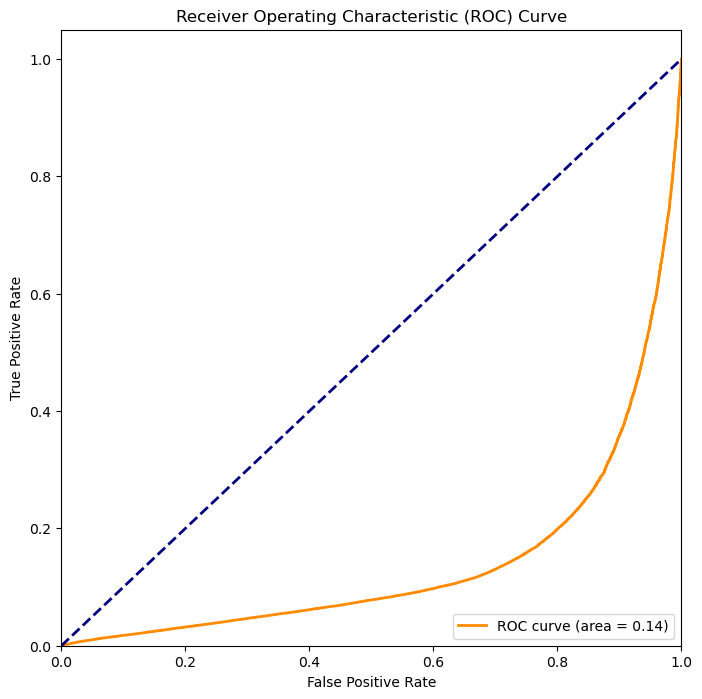

In [28]:
# Plot ROC curve
results = predictions.select(['probability', 'target']).collect()
results_list = [(float(i[0][1]), 1.0 - float(i[1])) for i in results]
fpr, tpr, _ = roc_curve([i[1] for i in results_list], [i[0] for i in results_list])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

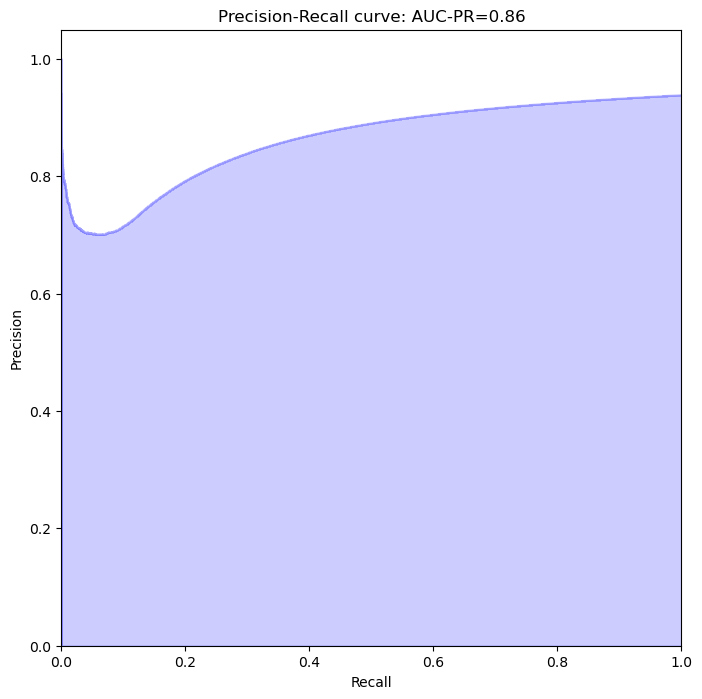

In [29]:
# Plot precision-recall curve
y_true = [i[1] for i in results_list]
y_scores = [i[0] for i in results_list]
precision, recall, _ = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)
plt.figure(figsize=(8, 8))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC-PR={0:0.2f}'.format(average_precision))
plt.show()

In [30]:
# save model. if running in databricks save to s3.
model_save_dir = datetime.datetime.now().strftime("%Y%m%d%H%M%S") + '-sentence-model'

if "DATABRICKS_RUNTIME_VERSION" in os.environ:
    try:
        dbutils.fs.ls(aws_s3_keys)
        aws_keys_df = spark.read.csv(aws_s3_keys)

        ACCESS_KEY = aws_keys_df.select('Access key ID').collect()[0]['Access key ID']
        SECRET_KEY = aws_keys_df.select('Secret access key').collect()[0]['Secret access key']
        ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
        # see https://docs.databricks.com/dbfs/mounts.html#mount-a-bucket-using-aws-keys for reference
        dbutils.fs.mount(f"s3a://{ACCESS_KEY}:{ENCODED_SECRET_KEY}@{s3_bucket_name}", s3_mount_path)
        lrModel.save(s3_mount_path + '/' + model_save_dir)
    except Exception as e:
        print('no aws access key file loaded, so model is not being saved to s3')
else:
    lrModel.save(model_save_dir)